<a href="https://colab.research.google.com/github/UkeshThapa/Human-Activities-recognition/blob/main/Research_Human_activities_Recognition_TML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research on Human Activities Recognition with TML
#### @author1 : John Bernardo
#### @email1 : jaybz.bernardo@gmail.com

####
#### @author2 : Bipun Man Pati Gubaju
#### @email2 : bemaanpati@gmail.com

#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------####



#### Code By:
#### @author : Ukesh Thapa
#### @email : yukeshthapa8@gmail.com


In [1]:
# import library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold


In [ ]:
def load_dataset_and_merge(file_paths):
  dfs = []

  # Loop through each file, read it into a DataFrame, and append to the list
  for file_path in file_paths:
      df = pd.read_excel(file_path)
      dfs.append(df)
  combined_df = pd.concat(dfs,axis=0, ignore_index=True)

  return combined_df



xlsx_name = ["aung","aung_ph","bipun","john","kaung","kavin","manash","person_2","person_3","praew","su"]



# 2 Sensors

# Non-overlapping Dataset

In [ ]:

file_path = "/content/drive/MyDrive/Colab Notebooks/Human Activities Recognition/Dataset/2 Sensors/non-overlapping/Train_Test_Data"

cv_data_name = []
for name in xlsx_name:
    cv_data_name.append(f"{file_path}/final_{name}.xlsx")

df_all = load_dataset_and_merge(cv_data_name)

normalize_all_data = df_all.iloc[:, :-1]
scaler = MinMaxScaler()
scaler.fit(normalize_all_data)

df_all.iloc[:, :-1] = scaler.transform(normalize_all_data)

X = df_all.iloc[:, :-1].values
y = df_all['output'].values

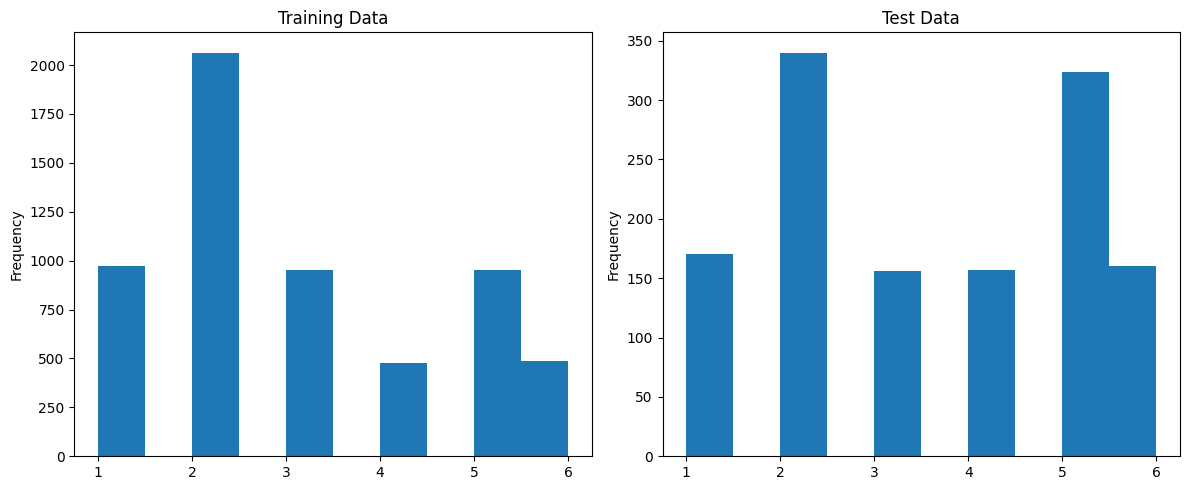

In [ ]:
# Data visulaization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot the output column for the training DataFrame in the first subplot (ax1)
ax1.set_title('Training Data')
# Add your visualization for the output column of the training data (e.g., histogram, bar plot, etc.)
df_all['output'].plot(kind='hist', ax=ax1)

# Plot the output column for the test DataFrame in the second subplot (ax2)
ax2.set_title('Test Data')
# Add your visualization for the output column of the test data (e.g., histogram, bar plot, etc.)
df_all['output'].plot(kind='hist', ax=ax2)

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Cross Validation

# knn

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],  # Specify the range of neighbors
    'weights': ['uniform', 'distance'],  # Weights for the neighbors
    'p': [1, 2]  # Distance metric (1 for Manhattan, 2 for Euclidean)
}

# Create a KNN classifier
knn = KNeighborsClassifier(metric='cosine')
# knn = KNeighborsClassifier()

folds = [10,20,30]


for fold in folds:
    # Define the outer cross-validation loop
    outer_cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

    # Initialize lists to store accuracy for each fold
    train_accuracies = []
    test_accuracies = []
    validation_accuracies = []
    # Create a tqdm progress bar for the combined outer and inner loop
    for fold_index, (train_index, test_index) in enumerate(tqdm(outer_cv.split(X, y), total=fold, desc="Nested CV Progress")):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create an inner cross-validation loop for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Initialize lists to store validation data for tracking validation accuracy
        val_X = []
        val_y = []

        # Create a tqdm progress bar for the inner loop
        for inner_index, (train_index, val_index) in enumerate(tqdm(inner_cv.split(X_train, y_train), total=3, desc="Inner CV Progress")):
            X_train_inner, X_val = X_train[train_index], X_train[val_index]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]

            # Create an inner grid search with the KNN model and parameter grid
            grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

            # Fit the grid search on the training data
            grid_search.fit(X_train_inner, y_train_inner)

            # Get the best hyperparameters from the grid search
            best_params = grid_search.best_params_

            # Create a KNN classifier with the best hyperparameters
            best_knn = KNeighborsClassifier(**best_params)

            # Fit the best KNN classifier on the training data
            best_knn.fit(X_train_inner, y_train_inner)



        # Calculate accuracy on the validation data
        train_accuracy = best_knn.score(X_train_inner, y_train_inner)
        train_accuracies.append(train_accuracy)

        # Calculate accuracy on the validation data
        validation_accuracy = best_knn.score(X_val, y_val)
        validation_accuracies.append(validation_accuracy)

        # Calculate accuracy on the test data
        test_accuracy = best_knn.score(X_test, y_test)
        test_accuracies.append(test_accuracy)

        # Update the outer progress bar description
        tqdm.write(f"Fold {fold_index + 1} - Test Accuracy: {test_accuracy:.2f}")

    # Calculate the average train, test, and validation accuracy
    average_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
    average_validation_accuracy = sum(validation_accuracies) / len(validation_accuracies)

    print(f"{fold} data")

    print("Average Train Accuracy:", average_train_accuracy)
    print("Average Test Accuracy:", average_test_accuracy)
    print("Average Validation Accuracy:", average_validation_accuracy)
    print("\n\n")


Mean Accuracy: 0.971
Mean Precision: 0.983
Mean Recall: 0.975
Mean F1-Score: 0.978


# Decision Tree

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],  # Specify the range of neighbors
    'weights': ['uniform', 'distance'],  # Weights for the neighbors
    'p': [1, 2]  # Distance metric (1 for Manhattan, 2 for Euclidean)
}

# Create a KNN classifier
knn = KNeighborsClassifier(metric='cosine')
# knn = KNeighborsClassifier()

folds = [10,20,30]


for fold in folds:
    # Define the outer cross-validation loop
    outer_cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

    # Initialize lists to store accuracy for each fold
    train_accuracies = []
    test_accuracies = []
    validation_accuracies = []
    # Create a tqdm progress bar for the combined outer and inner loop
    for fold_index, (train_index, test_index) in enumerate(tqdm(outer_cv.split(X, y), total=fold, desc="Nested CV Progress")):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create an inner cross-validation loop for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Initialize lists to store validation data for tracking validation accuracy
        val_X = []
        val_y = []

        # Create a tqdm progress bar for the inner loop
        for inner_index, (train_index, val_index) in enumerate(tqdm(inner_cv.split(X_train, y_train), total=3, desc="Inner CV Progress")):
            X_train_inner, X_val = X_train[train_index], X_train[val_index]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]

            # Create an inner grid search with the KNN model and parameter grid
            grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

            # Fit the grid search on the training data
            grid_search.fit(X_train_inner, y_train_inner)

            # Get the best hyperparameters from the grid search
            best_params = grid_search.best_params_

            # Create a KNN classifier with the best hyperparameters
            best_knn = KNeighborsClassifier(**best_params)

            # Fit the best KNN classifier on the training data
            best_knn.fit(X_train_inner, y_train_inner)



        # Calculate accuracy on the validation data
        train_accuracy = best_knn.score(X_train_inner, y_train_inner)
        train_accuracies.append(train_accuracy)

        # Calculate accuracy on the validation data
        validation_accuracy = best_knn.score(X_val, y_val)
        validation_accuracies.append(validation_accuracy)

        # Calculate accuracy on the test data
        test_accuracy = best_knn.score(X_test, y_test)
        test_accuracies.append(test_accuracy)

        # Update the outer progress bar description
        tqdm.write(f"Fold {fold_index + 1} - Test Accuracy: {test_accuracy:.2f}")

    # Calculate the average train, test, and validation accuracy
    average_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
    average_validation_accuracy = sum(validation_accuracies) / len(validation_accuracies)

    print(f"{fold} data")

    print("Average Train Accuracy:", average_train_accuracy)
    print("Average Test Accuracy:", average_test_accuracy)
    print("Average Validation Accuracy:", average_validation_accuracy)
    print("\n\n")


# 50% overlapping

In [ ]:

file_path = "/content/drive/MyDrive/Colab Notebooks/Human Activities Recognition/Dataset/2 Sensors/non-overlapping/Train_Test_Data"

cv_data_name = []
for name in xlsx_name:
    cv_data_name.append(f"{file_path}/final_{name}.xlsx")

df_all = load_dataset_and_merge(cv_data_name)

normalize_all_data = df_all.iloc[:, :-1]
scaler = MinMaxScaler()
scaler.fit(normalize_all_data)

df_all.iloc[:, :-1] = scaler.transform(normalize_all_data)

X = df_all.iloc[:, :-1].values
y = df_all['output'].values

# knn

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],  # Specify the range of neighbors
    'weights': ['uniform', 'distance'],  # Weights for the neighbors
    'p': [1, 2]  # Distance metric (1 for Manhattan, 2 for Euclidean)
}

# Create a KNN classifier
knn = KNeighborsClassifier(metric='cosine')
# knn = KNeighborsClassifier()

folds = [10,20,30]


for fold in folds:
    # Define the outer cross-validation loop
    outer_cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

    # Initialize lists to store accuracy for each fold
    train_accuracies = []
    test_accuracies = []
    validation_accuracies = []
    # Create a tqdm progress bar for the combined outer and inner loop
    for fold_index, (train_index, test_index) in enumerate(tqdm(outer_cv.split(X, y), total=fold, desc="Nested CV Progress")):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create an inner cross-validation loop for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Initialize lists to store validation data for tracking validation accuracy
        val_X = []
        val_y = []

        # Create a tqdm progress bar for the inner loop
        for inner_index, (train_index, val_index) in enumerate(tqdm(inner_cv.split(X_train, y_train), total=3, desc="Inner CV Progress")):
            X_train_inner, X_val = X_train[train_index], X_train[val_index]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]

            # Create an inner grid search with the KNN model and parameter grid
            grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

            # Fit the grid search on the training data
            grid_search.fit(X_train_inner, y_train_inner)

            # Get the best hyperparameters from the grid search
            best_params = grid_search.best_params_

            # Create a KNN classifier with the best hyperparameters
            best_knn = KNeighborsClassifier(**best_params)

            # Fit the best KNN classifier on the training data
            best_knn.fit(X_train_inner, y_train_inner)



        # Calculate accuracy on the validation data
        train_accuracy = best_knn.score(X_train_inner, y_train_inner)
        train_accuracies.append(train_accuracy)

        # Calculate accuracy on the validation data
        validation_accuracy = best_knn.score(X_val, y_val)
        validation_accuracies.append(validation_accuracy)

        # Calculate accuracy on the test data
        test_accuracy = best_knn.score(X_test, y_test)
        test_accuracies.append(test_accuracy)

        # Update the outer progress bar description
        tqdm.write(f"Fold {fold_index + 1} - Test Accuracy: {test_accuracy:.2f}")

    # Calculate the average train, test, and validation accuracy
    average_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
    average_validation_accuracy = sum(validation_accuracies) / len(validation_accuracies)

    print(f"{fold} data")

    print("Average Train Accuracy:", average_train_accuracy)
    print("Average Test Accuracy:", average_test_accuracy)
    print("Average Validation Accuracy:", average_validation_accuracy)
    print("\n\n")


# decision Tree

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],  # Specify the range of neighbors
    'weights': ['uniform', 'distance'],  # Weights for the neighbors
    'p': [1, 2]  # Distance metric (1 for Manhattan, 2 for Euclidean)
}

# Create a KNN classifier
knn = KNeighborsClassifier(metric='cosine')
# knn = KNeighborsClassifier()

folds = [10,20,30]


for fold in folds:
    # Define the outer cross-validation loop
    outer_cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

    # Initialize lists to store accuracy for each fold
    train_accuracies = []
    test_accuracies = []
    validation_accuracies = []
    # Create a tqdm progress bar for the combined outer and inner loop
    for fold_index, (train_index, test_index) in enumerate(tqdm(outer_cv.split(X, y), total=fold, desc="Nested CV Progress")):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create an inner cross-validation loop for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Initialize lists to store validation data for tracking validation accuracy
        val_X = []
        val_y = []

        # Create a tqdm progress bar for the inner loop
        for inner_index, (train_index, val_index) in enumerate(tqdm(inner_cv.split(X_train, y_train), total=3, desc="Inner CV Progress")):
            X_train_inner, X_val = X_train[train_index], X_train[val_index]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]

            # Create an inner grid search with the KNN model and parameter grid
            grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

            # Fit the grid search on the training data
            grid_search.fit(X_train_inner, y_train_inner)

            # Get the best hyperparameters from the grid search
            best_params = grid_search.best_params_

            # Create a KNN classifier with the best hyperparameters
            best_knn = KNeighborsClassifier(**best_params)

            # Fit the best KNN classifier on the training data
            best_knn.fit(X_train_inner, y_train_inner)



        # Calculate accuracy on the validation data
        train_accuracy = best_knn.score(X_train_inner, y_train_inner)
        train_accuracies.append(train_accuracy)

        # Calculate accuracy on the validation data
        validation_accuracy = best_knn.score(X_val, y_val)
        validation_accuracies.append(validation_accuracy)

        # Calculate accuracy on the test data
        test_accuracy = best_knn.score(X_test, y_test)
        test_accuracies.append(test_accuracy)

        # Update the outer progress bar description
        tqdm.write(f"Fold {fold_index + 1} - Test Accuracy: {test_accuracy:.2f}")

    # Calculate the average train, test, and validation accuracy
    average_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
    average_validation_accuracy = sum(validation_accuracies) / len(validation_accuracies)

    print(f"{fold} data")

    print("Average Train Accuracy:", average_train_accuracy)
    print("Average Test Accuracy:", average_test_accuracy)
    print("Average Validation Accuracy:", average_validation_accuracy)
    print("\n\n")
